# Health insurance customer prediction 

In this notebook, we analyze dataset of a health insurance company. The company is planning to introduce vehicle insurance and wants to understand whether their past customers will also be interested in vehicle insurance. 

Let's start by importing necessary libraries.

## Import necessary libraries 

In [113]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import ExtraTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import pickle
from time import time

import warnings
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')        

## Load the dataset 

In [67]:
train_df = pd.read_csv("train.csv")
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
print("There are total {} samples present in the dataset each with {} features."
      .format(train_df.shape[0], train_df.shape[1]))

There are total 381109 samples present in the dataset each with 12 features.


In [5]:
train_df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


How many 'object' type features do we have in the dataset?

In [9]:
train_df.select_dtypes(include='object').columns

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')

How many categories are present in each of these above features?

In [7]:
train_df.select_dtypes(include='object').nunique()

Gender            2
Vehicle_Age       3
Vehicle_Damage    2
dtype: int64

## Exploratory data analysis 

### 1. male:female ratio among the customers of the company and how likely they are to respond positively for the vehicle insurance 

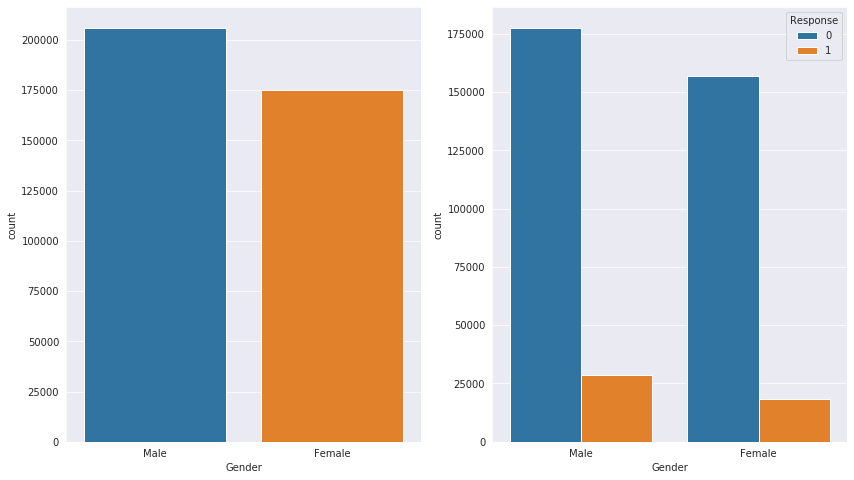

In [7]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
sns.countplot(x='Gender', data=train_df, ax=ax[0])
sns.countplot(x='Gender', hue='Response', data=train_df, ax=ax[1])

In [14]:
print("response:no response ratio for male customers : {}"
.format(len(train_df[(train_df['Gender']=='Male') & (train_df['Response']==1)])/len(train_df[(train_df['Gender']=='Male') & (train_df['Response']==0)])))

response:no response ratio for male customers : 0.16064630217836948


In [15]:
print("response:no response ratio for female customers : {}"
.format(len(train_df[(train_df['Gender']=='Female') & (train_df['Response']==1)])/len(train_df[(train_df['Gender']=='Female') & (train_df['Response']==0)])))

response:no response ratio for female customers : 0.11594988363566806


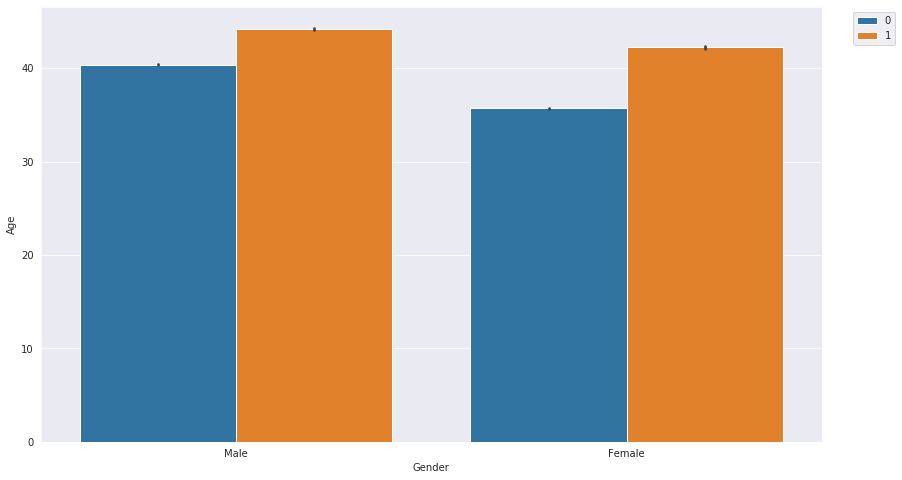

In [8]:
plt.figure(figsize=(14,8))
sns.barplot(x='Gender', y='Age', hue='Response', data=train_df)
plt.legend(loc='upper right', bbox_to_anchor=(1.1,1.0))

**Observations:**
- male customers are greater in number as compared to female customers.
- response:no response ratio for the vehicle insurance is also greater for male customers.
- interestingly customers (both male and female) with comparatively high values of average age are more likely to 
  respond positively for the vehicle insurance.

### 2. Do customers with driving license have higher chance to go for vehicle insurance? What about customers who already have vehicle insurance? 

<AxesSubplot:xlabel='Driving_License', ylabel='count'>

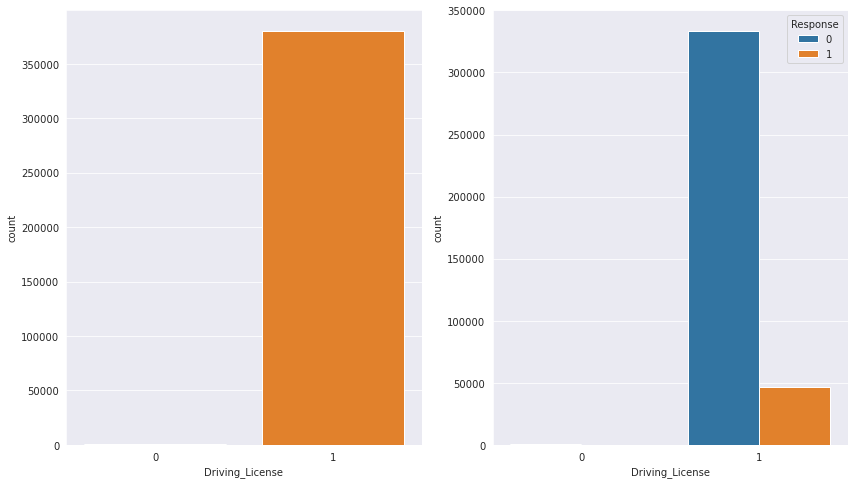

In [20]:
fig,ax = plt.subplots(1,2,figsize=(14,8))
sns.countplot('Driving_License', data=train_df, ax=ax[0])
sns.countplot('Driving_License', hue='Response', data=train_df, ax=ax[1])

<AxesSubplot:xlabel='Driving_License', ylabel='count'>

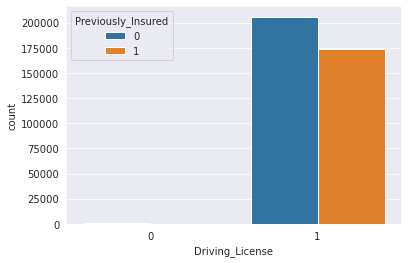

In [21]:
sns.countplot('Driving_License', hue='Previously_Insured', data=train_df)

<AxesSubplot:xlabel='Previously_Insured', ylabel='count'>

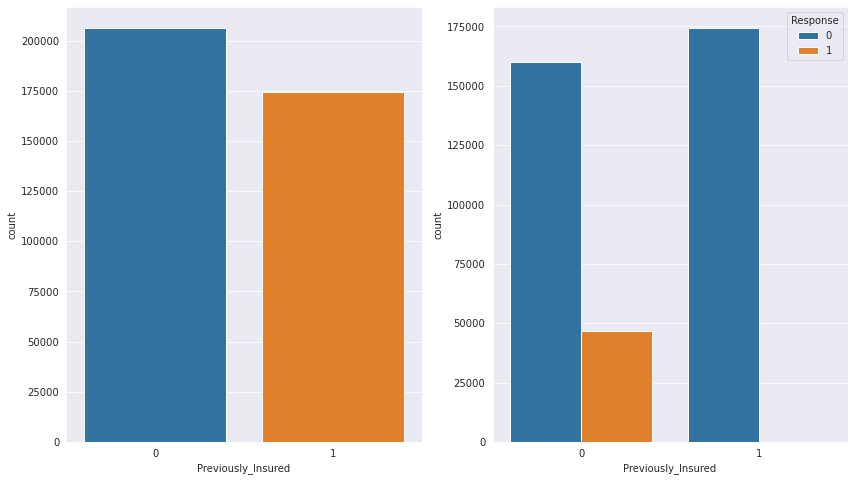

In [24]:
fig,ax = plt.subplots(1,2,figsize=(14,8))
sns.countplot('Previously_Insured', data=train_df, ax=ax[0])
sns.countplot('Previously_Insured', hue='Response', data=train_df, ax=ax[1])

**Observations:**
- all of the customers of the company have driving licenses although most of them have not shown interest in the  vehicle insurance scheme of the company.
- interestingly, the number of customers with vehicle insurance is lesser than those with no vehicle insurance (where both of them have driving licenses).
- the number of customers already having vehicle insurance is slightly lesser than those with no vehicle insurance.
- most of the customers with vehicle insurances want to stick to their old scheme. Also, even people with no previous vehicle insurance have shown less interest to invest in this company.

### 3. How many customers have vehicle accident history in the past? Does it have any effect on their response? 

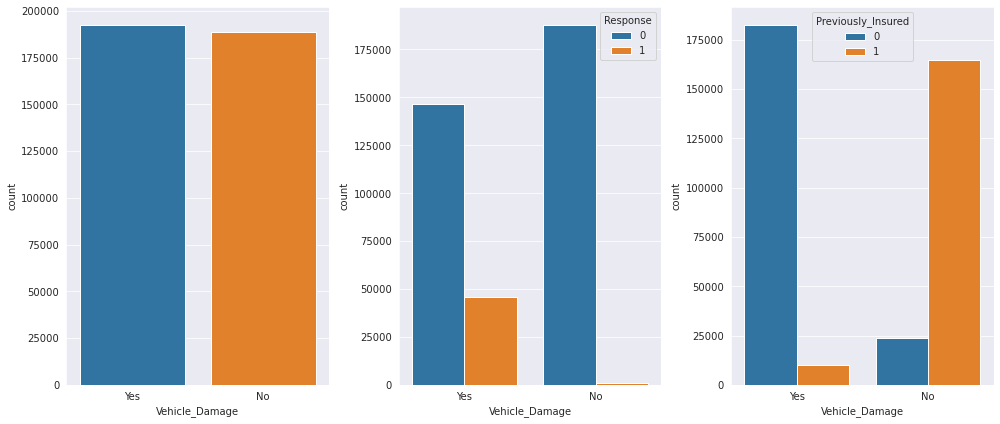

In [28]:
fig, ax = plt.subplots(1,3,figsize=(14,6))
sns.countplot('Vehicle_Damage', data=train_df, ax=ax[0])
sns.countplot('Vehicle_Damage', hue='Response', data=train_df, ax=ax[1])
sns.countplot('Vehicle_Damage', hue='Previously_Insured', data=train_df, ax=ax[2])
plt.tight_layout()

**Observations:**
- number of customers with previous vehicle accident history is almost comparable to those with no such history.
- almost none of the customers with no previous vehicle accident history has responded to the vehicle insurance scheme of the company (middle plot). This is because most of them already have their vehicles insured (right-most plot). 

### 4. What is the age distribution of the customers?

<AxesSubplot:xlabel='Age', ylabel='Density'>

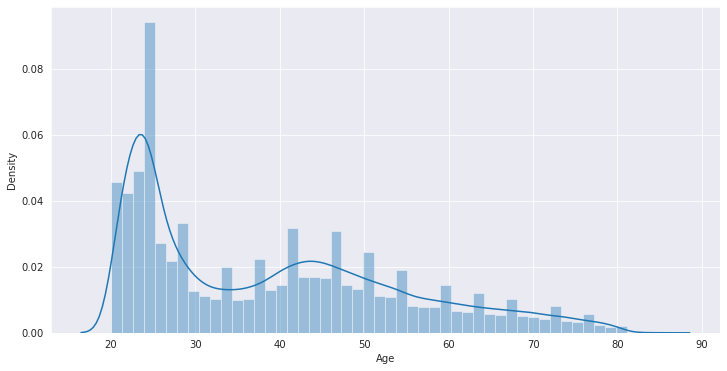

In [29]:
plt.figure(figsize=(12,6))
sns.distplot(train_df['Age'])

**Observation:**
- A large chunk of customers have age in the range 20 to 40 years.

### 5. Do customers with comparatively new vehicles have higher chance to insure it through the company? or they have already done it?

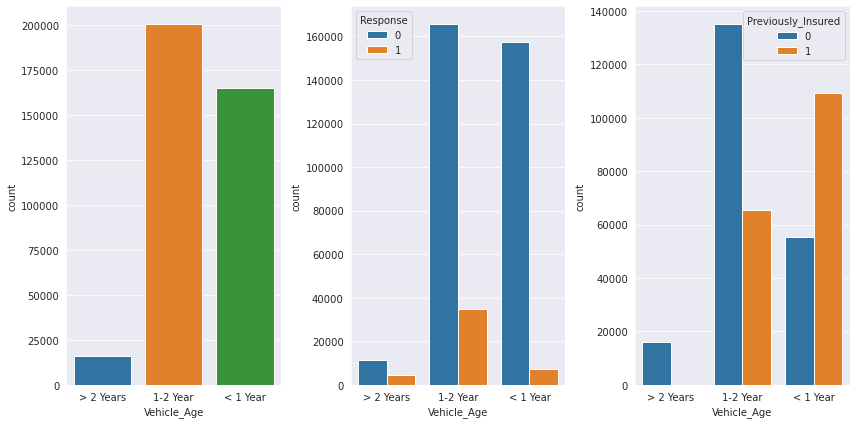

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(12,6))
sns.countplot('Vehicle_Age', data=train_df, ax=ax[0])
sns.countplot('Vehicle_Age', hue='Response', data=train_df, ax=ax[1])
sns.countplot('Vehicle_Age', hue='Previously_Insured', data=train_df, ax=ax[2])
plt.tight_layout()

**Observations:**
- most of the customers have comparatively new vehicles (left-most plot) and are less likely to insure the vehicles through this company (middle plot).
- this is because a large number among them have already insured their vehicles (especiaally those with most recent vehicles).
- interestingly, people with quite old vehicles have not made any insurance.

### 6. What role does the total amount of premium play?

(0.0, 100000.0)

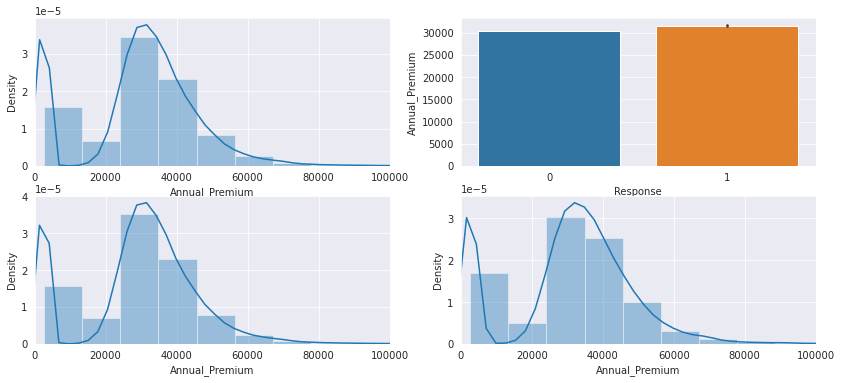

In [39]:
fig, ax = plt.subplots(2,2,figsize=(14,6))
sns.distplot(train_df['Annual_Premium'], ax=ax[0,0])
sns.barplot(x='Response', y='Annual_Premium', data=train_df, ax=ax[0,1])
sns.distplot(train_df[train_df['Response']==0]['Annual_Premium'], ax=ax[1,0])
sns.distplot(train_df[train_df['Response']==1]['Annual_Premium'], ax=ax[1,1])
ax[0,0].set_xlim([0,100000])
ax[1,0].set_xlim([0,100000])
ax[1,1].set_xlim([0,100000])

In [37]:
train_df['Annual_Premium'].mean()

30564.389581458323

**Observations:**
- most of the schemes for the annual premium of vehicle insurance lies in the range 20k - 40k with an average of 30.5k (upper left plot).
- interestingly, the average value of the annual premium is comparable for customers who have responded and who haven't (upper right and bottom plots).

### 7. How do different marketting schemes affect customer's responses?

<AxesSubplot:xlabel='Policy_Sales_Channel', ylabel='Density'>

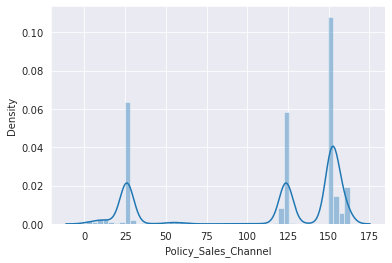

In [40]:
sns.distplot(train_df['Policy_Sales_Channel'])

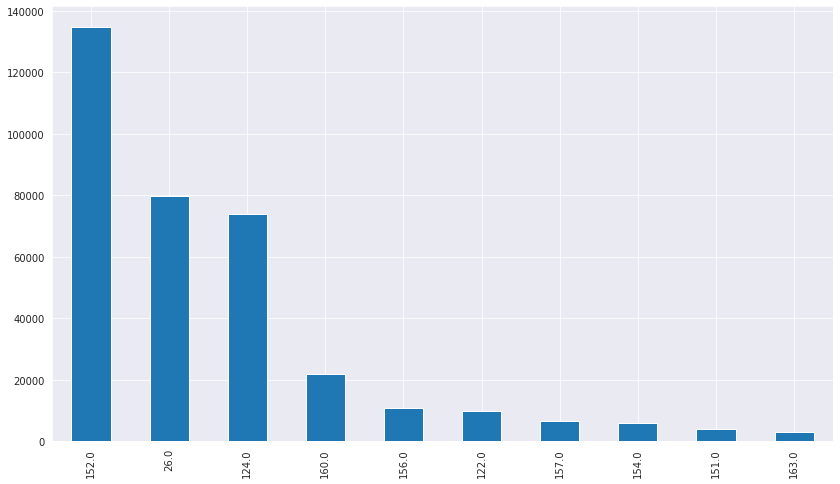

In [41]:
# top 10 marketting channels used by the company
train_df['Policy_Sales_Channel'].value_counts().head(10).plot(kind='bar', figsize=(14,8))

<AxesSubplot:>

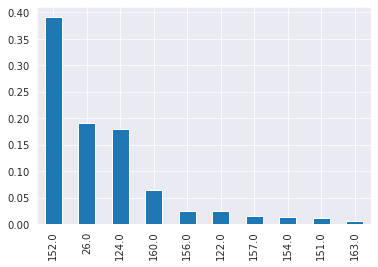

In [41]:
# top 10 marketting channels for the customers who didn't respond
train_df[train_df['Response']==0]['Policy_Sales_Channel'].value_counts(normalize=True).head(10).plot(kind='bar')

<AxesSubplot:>

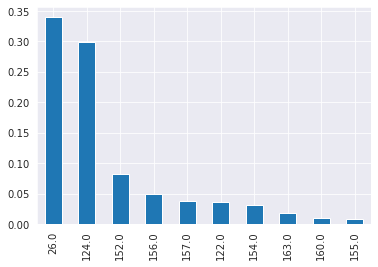

In [42]:
# top 10 marketting channels for the customers who responded
train_df[train_df['Response']==1]['Policy_Sales_Channel'].value_counts(normalize=True).head(10).plot(kind='bar')

**Observations:**
- most used policy sale channels by the company are - 152, 26, 124 (first two plots).
- two most promising channels to attract customers are - 26  and 124 (last plot).
- although channel 152 is one of the most used channels by the company, it has failed to increse the number of customers.

### 8. Are older customers of the company likely to insure their vehicles through the company as well? 

<AxesSubplot:>

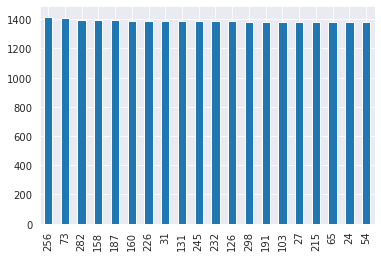

In [51]:
train_df['Vintage'].value_counts().head(20).plot(kind='bar')

In [53]:
train_df.groupby('Vintage')['Response'].count().sort_values(ascending=False)

Vintage
256    1418
73     1410
282    1397
158    1394
187    1392
       ... 
205    1235
89     1234
32     1230
224    1227
277    1226
Name: Response, Length: 290, dtype: int64

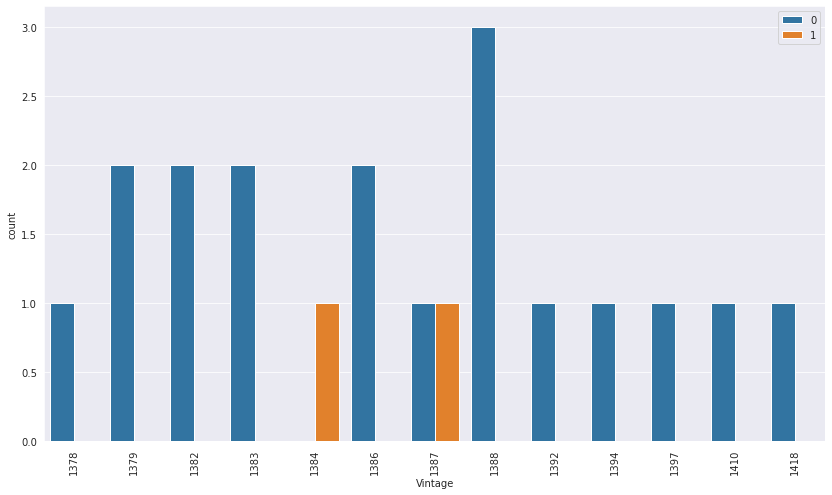

In [49]:
plt.figure(figsize=(14,8))
sns.countplot(train_df['Vintage'].value_counts().head(20), hue=train_df['Response'])
plt.xticks(rotation=90)
plt.legend(loc='upper right');

## Data processing 

In [54]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


### 1. Check for null values 

In [86]:
train_df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

### 2. Check for duplicate values

In [68]:
# drop the 'id' column since it won't be used during model traiing
final_train_df = train_df.drop('id', axis=1)

In [70]:
final_train_df[final_train_df.duplicated()]

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
35754,Male,23,1,15.0,0,< 1 Year,No,2630.0,152.0,173,0
41515,Male,39,1,30.0,0,1-2 Year,Yes,2630.0,124.0,27,0
43618,Male,40,1,28.0,1,1-2 Year,No,2630.0,124.0,209,0
44049,Male,39,1,28.0,0,1-2 Year,Yes,2630.0,124.0,64,0
44203,Male,44,1,28.0,0,> 2 Years,Yes,2630.0,124.0,155,1
...,...,...,...,...,...,...,...,...,...,...,...
379273,Male,58,1,30.0,1,1-2 Year,No,2630.0,152.0,150,0
379451,Male,41,1,30.0,0,1-2 Year,Yes,2630.0,156.0,111,0
379788,Male,38,1,28.0,1,1-2 Year,No,2630.0,124.0,42,0
380673,Female,37,1,28.0,0,1-2 Year,Yes,2630.0,156.0,176,0


So, there are total 269 duplicate rows. Let's drop them.

In [71]:
final_train_df.drop_duplicates(inplace=True)

In [72]:
print("The shape of the dataframe after dropping duplicate rows is : {}".format(final_train_df.shape))

The shape of the dataframe after dropping duplicate rows is : (380840, 11)


### 3. Encode categorical features 

In [78]:
for col in final_train_df.select_dtypes(include='object').columns:
    print(col, ":", final_train_df[col].unique())
    print()

Gender : ['Male' 'Female']

Vehicle_Age : ['> 2 Years' '1-2 Year' '< 1 Year']

Vehicle_Damage : ['Yes' 'No']



In [79]:
# encoding binary categorical features
final_train_df.replace({'Male':0, 'Female':1, 'No':0, 'Yes':1}, inplace=True)
final_train_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,44,1,28.0,0,> 2 Years,1,40454.0,26.0,217,1
1,0,76,1,3.0,0,1-2 Year,0,33536.0,26.0,183,0
2,0,47,1,28.0,0,> 2 Years,1,38294.0,26.0,27,1
3,0,21,1,11.0,1,< 1 Year,0,28619.0,152.0,203,0
4,1,29,1,41.0,1,< 1 Year,0,27496.0,152.0,39,0


In [81]:
# create dummy variables for the categorical feature with more than two classes
final_train_df = pd.get_dummies(final_train_df, drop_first=True)
final_train_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,0,44,1,28.0,0,1,40454.0,26.0,217,1,0,1
1,0,76,1,3.0,0,0,33536.0,26.0,183,0,0,0
2,0,47,1,28.0,0,1,38294.0,26.0,27,1,0,1
3,0,21,1,11.0,1,0,28619.0,152.0,203,0,1,0
4,1,29,1,41.0,1,0,27496.0,152.0,39,0,1,0


### 4. Check for correlated fetaures 

<AxesSubplot:>

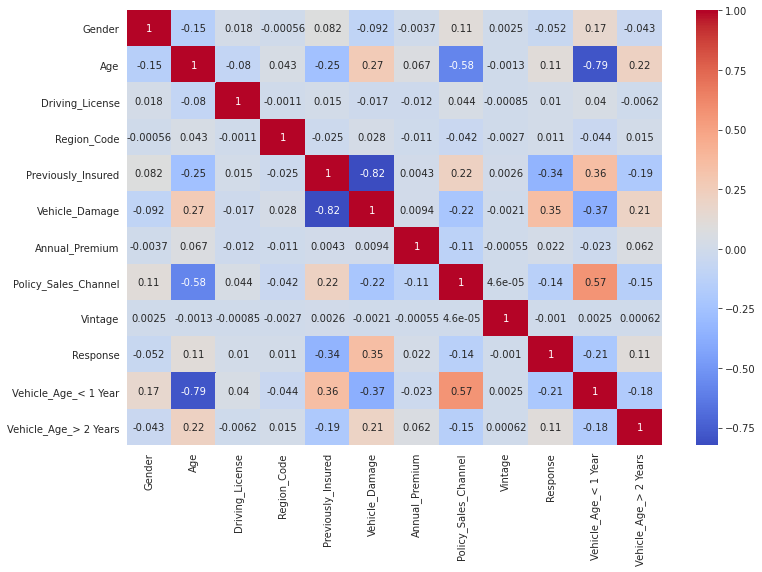

In [85]:
corr_df = final_train_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')

It is clear from the above heatmap that highest correlation (negative correlation) exists between the feature pair (Vehicle_damage, Previously_Insured). Most of the feature pairs donot have strong correlation. Hence, we decide not to drop any fetaure based on correlation.

###  5. Create the feature matrix and target vector

In [82]:
# the feature matrix
X = final_train_df.drop('Response', axis=1)

# the target vector
y = final_train_df['Response']

In [83]:
X.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,0,44,1,28.0,0,1,40454.0,26.0,217,0,1
1,0,76,1,3.0,0,0,33536.0,26.0,183,0,0
2,0,47,1,28.0,0,1,38294.0,26.0,27,0,1
3,0,21,1,11.0,1,0,28619.0,152.0,203,1,0
4,1,29,1,41.0,1,0,27496.0,152.0,39,1,0


In [87]:
# distribution of classes in the target variable
y.value_counts(normalize=True)

0    0.877416
1    0.122584
Name: Response, dtype: float64

<AxesSubplot:>

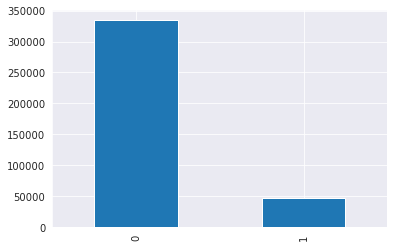

In [88]:
y.value_counts().plot(kind='bar')

So, our target variable is highly imbalanced.

### 6. Split the dataset 

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("The shape of the training set is {}".format(X_train.shape))
print("The shape of the training set is {}".format(X_test.shape))

The shape of the training set is (266588, 11)
The shape of the training set is (114252, 11)


In [11]:
y_train.value_counts(normalize=True)

0    0.877489
1    0.122511
Name: Response, dtype: float64

In [12]:
y_test.value_counts(normalize=True)

0    0.877245
1    0.122755
Name: Response, dtype: float64

## Model building

In [92]:
def build_pipeline(clf):
    
    """
    Function to build a data pipeline consisting of the following steps :
    
    1. over : oversampling the minority class (response=1) class using SMOTE technique.
    2. under : undersampling the majority class (response=0).
    3. scaler : standardizing the dataset.
    4. clf : the classification algorithm.
    
    Parameter
    ----------
    clf : object of a class
       the classification class object
       
    Returns   
    ---------
    pipeline : object of a class
       the data pipeline object 
    
    """
    
    over = SMOTE(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy=0.5)
    scaler = StandardScaler()
    
    pipeline = Pipeline([
                        ('over', over),
                        ('under', under),
                        ('scaler', scaler),
                        ('clf', clf)
                       ])
    return pipeline

In [13]:
# list of classifiers to be analyzed
clf_list = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), 
            AdaBoostClassifier(), XGBClassifier()]

# list of dictionaries of parameters and corresponding values associated with each of the classifiers in the above 
# list that will be used during grid search

param_list = [
             {
              'clf__C':[0.01, 0.05, 0.1, 0.3],
              'clf__class_weight':[None, 'balanced']                
             },
             {
              'clf__n_neighbors':[5, 10, 15, 20],
              'clf__weights':['uniform', 'distance']   
             },
             {
              'clf__n_estimators':[80, 100, 150],
              'clf__criterion':['gini', 'entropy'],
              'clf__class_weight':[None, 'balanced']   
             },
             {
              'clf__n_estimators':[80, 100, 150],
              'clf__learning_rate':[0.001, 0.01, 0.1]   
             },
             {
              'clf__n_estimators':[80, 100, 150],
              'clf__learning_rate':[0.001, 0.01, 0.1]                    
             }
             ]

In [15]:
roc_score_max = 0.

# loop over classifiers and corresponding dictionary of parameters
for param_dict, clf in zip(param_list, clf_list):
    
    # build the pipeline
    pipeline = build_pipeline(clf)
    print("Now running the model : {}".format(pipeline.steps[3][1]))
    
    # build the GridSearchCV object
    grid_cv = GridSearchCV(pipeline, param_grid=param_dict, cv=3, scoring='roc_auc', verbose=2)
    print()
    initial_time = time()
    
    # fit this object to the training set
    grid_cv.fit(X_train, y_train)
    train_time = time() - initial_time
    print("total time taken for fitting the model : {}".format(train_time))
    print()
    
    # make predictions on the test set
    pred = grid_cv.predict_proba(X_test)
    
    # compute the roc_auc score for the test set
    roc_score = roc_auc_score(y_test,pred[:, 1:])
    
    # store the best roc_score and the corresponding classifier
    if roc_score > roc_score_max:
        roc_score_max = roc_score
        opt_model = pipeline.steps[3][1]
        opt_param = grid_cv.best_params_
        opt_val_score, opt_test_score = grid_cv.best_score_, roc_score_max
        
        
print("the best model is {} for the parameter set {} that produces an roc_auc_score {} when evaluated on the train set and roc_auc_score {} when evaluated on the test set."
      .format(opt_model, opt_param, opt_val_score, opt_test_score))        

Now running the model : LogisticRegression()

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__C=0.01, clf__class_weight=None .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. clf__C=0.01, clf__class_weight=None, total=   0.9s
[CV] clf__C=0.01, clf__class_weight=None .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] .............. clf__C=0.01, clf__class_weight=None, total=   0.6s
[CV] clf__C=0.01, clf__class_weight=None .............................
[CV] .............. clf__C=0.01, clf__class_weight=None, total=   0.6s
[CV] clf__C=0.01, clf__class_weight=balanced .........................
[CV] .......... clf__C=0.01, clf__class_weight=balanced, total=   0.7s
[CV] clf__C=0.01, clf__class_weight=balanced .........................
[CV] .......... clf__C=0.01, clf__class_weight=balanced, total=   0.6s
[CV] clf__C=0.01, clf__class_weight=balanced .........................
[CV] .......... clf__C=0.01, clf__class_weight=balanced, total=   0.6s
[CV] clf__C=0.05, clf__class_weight=None .............................
[CV] .............. clf__C=0.05, clf__class_weight=None, total=   0.6s
[CV] clf__C=0.05, clf__class_weight=None .............................
[CV] .............. clf__C=0.05, clf__class_weight=None, total=   0.6s
[CV] clf__C=0.05, clf__class_weight=None .............................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   14.2s finished


total time taken for fitting the model : 15.197306632995605

Now running the model : KNeighborsClassifier()

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__n_neighbors=5, clf__weights=uniform ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... clf__n_neighbors=5, clf__weights=uniform, total=  30.4s
[CV] clf__n_neighbors=5, clf__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.4s remaining:    0.0s


[CV] ......... clf__n_neighbors=5, clf__weights=uniform, total=  31.0s
[CV] clf__n_neighbors=5, clf__weights=uniform ........................
[CV] ......... clf__n_neighbors=5, clf__weights=uniform, total=  29.5s
[CV] clf__n_neighbors=5, clf__weights=distance .......................
[CV] ........ clf__n_neighbors=5, clf__weights=distance, total=  30.5s
[CV] clf__n_neighbors=5, clf__weights=distance .......................
[CV] ........ clf__n_neighbors=5, clf__weights=distance, total=  29.0s
[CV] clf__n_neighbors=5, clf__weights=distance .......................
[CV] ........ clf__n_neighbors=5, clf__weights=distance, total=  29.5s
[CV] clf__n_neighbors=10, clf__weights=uniform .......................
[CV] ........ clf__n_neighbors=10, clf__weights=uniform, total=  36.7s
[CV] clf__n_neighbors=10, clf__weights=uniform .......................
[CV] ........ clf__n_neighbors=10, clf__weights=uniform, total=  36.2s
[CV] clf__n_neighbors=10, clf__weights=uniform .......................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 15.7min finished


total time taken for fitting the model : 958.2849593162537

Now running the model : RandomForestClassifier()

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__class_weight=None, clf__criterion=gini, clf__n_estimators=80 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__class_weight=None, clf__criterion=gini, clf__n_estimators=80, total=  10.1s
[CV] clf__class_weight=None, clf__criterion=gini, clf__n_estimators=80 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s


[CV]  clf__class_weight=None, clf__criterion=gini, clf__n_estimators=80, total=   8.9s
[CV] clf__class_weight=None, clf__criterion=gini, clf__n_estimators=80 
[CV]  clf__class_weight=None, clf__criterion=gini, clf__n_estimators=80, total=   8.7s
[CV] clf__class_weight=None, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__class_weight=None, clf__criterion=gini, clf__n_estimators=100, total=  10.8s
[CV] clf__class_weight=None, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__class_weight=None, clf__criterion=gini, clf__n_estimators=100, total=  10.8s
[CV] clf__class_weight=None, clf__criterion=gini, clf__n_estimators=100 
[CV]  clf__class_weight=None, clf__criterion=gini, clf__n_estimators=100, total=  10.9s
[CV] clf__class_weight=None, clf__criterion=gini, clf__n_estimators=150 
[CV]  clf__class_weight=None, clf__criterion=gini, clf__n_estimators=150, total=  16.2s
[CV] clf__class_weight=None, clf__criterion=gini, clf__n_estimators=150 
[CV]  clf__class_weight=None, clf__cr

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  8.8min finished


total time taken for fitting the model : 592.5397548675537

Now running the model : AdaBoostClassifier()

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] clf__learning_rate=0.001, clf__n_estimators=80 ..................
[CV] ... clf__learning_rate=0.001, clf__n_estimators=80, total=  14.0s
[CV] clf__learning_rate=0.001, clf__n_estimators=80 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s remaining:    0.0s


[CV] ... clf__learning_rate=0.001, clf__n_estimators=80, total=   4.8s
[CV] clf__learning_rate=0.001, clf__n_estimators=80 ..................
[CV] ... clf__learning_rate=0.001, clf__n_estimators=80, total=   4.9s
[CV] clf__learning_rate=0.001, clf__n_estimators=100 .................
[CV] .. clf__learning_rate=0.001, clf__n_estimators=100, total=   6.2s
[CV] clf__learning_rate=0.001, clf__n_estimators=100 .................
[CV] .. clf__learning_rate=0.001, clf__n_estimators=100, total=   7.0s
[CV] clf__learning_rate=0.001, clf__n_estimators=100 .................
[CV] .. clf__learning_rate=0.001, clf__n_estimators=100, total=   6.1s
[CV] clf__learning_rate=0.001, clf__n_estimators=150 .................
[CV] .. clf__learning_rate=0.001, clf__n_estimators=150, total=   8.9s
[CV] clf__learning_rate=0.001, clf__n_estimators=150 .................
[CV] .. clf__learning_rate=0.001, clf__n_estimators=150, total=   8.9s
[CV] clf__learning_rate=0.001, clf__n_estimators=150 .................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  4.9min finished


total time taken for fitting the model : 311.64762568473816

Now running the model : XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] clf__learning_rate=0.001, clf__n_estimators=80 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... clf__learning_rate=0.001, clf__n_estimators=80, total=   5.3s
[CV] clf__learning_rate=0.001, clf__n_estimators=80 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] ... clf__learning_rate=0.001, clf__n_estimators=80, total=   2.6s
[CV] clf__learning_rate=0.001, clf__n_estimators=80 ..................
[CV] ... clf__learning_rate=0.001, clf__n_estimators=80, total=   2.4s
[CV] clf__learning_rate=0.001, clf__n_estimators=100 .................
[CV] .. clf__learning_rate=0.001, clf__n_estimators=100, total=   2.8s
[CV] clf__learning_rate=0.001, clf__n_estimators=100 .................
[CV] .. clf__learning_rate=0.001, clf__n_estimators=100, total=   2.8s
[CV] clf__learning_rate=0.001, clf__n_estimators=100 .................
[CV] .. clf__learning_rate=0.001, clf__n_estimators=100, total=   3.4s
[CV] clf__learning_rate=0.001, clf__n_estimators=150 .................
[CV] .. clf__learning_rate=0.001, clf__n_estimators=150, total=   5.1s
[CV] clf__learning_rate=0.001, clf__n_estimators=150 .................
[CV] .. clf__learning_rate=0.001, clf__n_estimators=150, total=   4.8s
[CV] clf__learning_rate=0.001, clf__n_estimators=150 .................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.8min finished


total time taken for fitting the model : 114.5344808101654

the best model is XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None) for the parameter set {'clf__learning_rate': 0.1, 'clf__n_estimators': 150} that produces an roc_auc_score 0.8530182934346179 when evaluated on the train set and roc_auc_score 0.8530633898633144 when evaluated on the test set.


In [94]:
# further optimization of the best model found during grid search
xgb = XGBClassifier()

param_dict = {'clf__n_estimators':list(np.arange(250,600,50)),
              'clf__learning_rate':list(np.round(np.arange(0.1,0.8,0.15),2)),
              'clf__scale_pos_weight':[0.3,0.4,0.5] }


pipeline = build_pipeline(xgb)
grid_cv = GridSearchCV(pipeline, param_grid=param_dict, cv=5, scoring='roc_auc', verbose=2)

initial_time = time()
grid_cv.fit(X_train, y_train)
train_time = time() - initial_time
print("total time taken for fitting the model : {}".format(train_time))
print()
pred = grid_cv.predict_proba(X_test)
roc_score = roc_auc_score(y_test,pred[:, 1:])

Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] clf__learning_rate=0.1, clf__n_estimators=250, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.1, clf__n_estimators=250, clf__scale_pos_weight=0.3, total=  34.0s
[CV] clf__learning_rate=0.1, clf__n_estimators=250, clf__scale_pos_weight=0.3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.0s remaining:    0.0s


[CV]  clf__learning_rate=0.1, clf__n_estimators=250, clf__scale_pos_weight=0.3, total=  28.8s
[CV] clf__learning_rate=0.1, clf__n_estimators=250, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.1, clf__n_estimators=250, clf__scale_pos_weight=0.3, total=  30.0s
[CV] clf__learning_rate=0.1, clf__n_estimators=250, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.1, clf__n_estimators=250, clf__scale_pos_weight=0.3, total=  30.5s
[CV] clf__learning_rate=0.1, clf__n_estimators=250, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.1, clf__n_estimators=250, clf__scale_pos_weight=0.3, total=  29.0s
[CV] clf__learning_rate=0.1, clf__n_estimators=250, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.1, clf__n_estimators=250, clf__scale_pos_weight=0.4, total=  29.1s
[CV] clf__learning_rate=0.1, clf__n_estimators=250, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.1, clf__n_estimators=250, clf__scale_pos_weight=0.4, total=  29.1s
[CV] clf__learning_rate=0.1, clf__n_estim

[CV]  clf__learning_rate=0.1, clf__n_estimators=400, clf__scale_pos_weight=0.3, total=  43.7s
[CV] clf__learning_rate=0.1, clf__n_estimators=400, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.1, clf__n_estimators=400, clf__scale_pos_weight=0.4, total=  46.3s
[CV] clf__learning_rate=0.1, clf__n_estimators=400, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.1, clf__n_estimators=400, clf__scale_pos_weight=0.4, total=  45.4s
[CV] clf__learning_rate=0.1, clf__n_estimators=400, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.1, clf__n_estimators=400, clf__scale_pos_weight=0.4, total=  44.9s
[CV] clf__learning_rate=0.1, clf__n_estimators=400, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.1, clf__n_estimators=400, clf__scale_pos_weight=0.4, total=  44.9s
[CV] clf__learning_rate=0.1, clf__n_estimators=400, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.1, clf__n_estimators=400, clf__scale_pos_weight=0.4, total=  43.5s
[CV] clf__learning_rate=0.1, clf__n_estim

[CV]  clf__learning_rate=0.1, clf__n_estimators=550, clf__scale_pos_weight=0.4, total= 1.0min
[CV] clf__learning_rate=0.1, clf__n_estimators=550, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.1, clf__n_estimators=550, clf__scale_pos_weight=0.4, total= 1.0min
[CV] clf__learning_rate=0.1, clf__n_estimators=550, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.1, clf__n_estimators=550, clf__scale_pos_weight=0.4, total=  59.8s
[CV] clf__learning_rate=0.1, clf__n_estimators=550, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.1, clf__n_estimators=550, clf__scale_pos_weight=0.5, total= 1.0min
[CV] clf__learning_rate=0.1, clf__n_estimators=550, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.1, clf__n_estimators=550, clf__scale_pos_weight=0.5, total= 1.0min
[CV] clf__learning_rate=0.1, clf__n_estimators=550, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.1, clf__n_estimators=550, clf__scale_pos_weight=0.5, total= 1.0min
[CV] clf__learning_rate=0.1, clf__n_estim

[CV]  clf__learning_rate=0.25, clf__n_estimators=350, clf__scale_pos_weight=0.4, total=  45.9s
[CV] clf__learning_rate=0.25, clf__n_estimators=350, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.25, clf__n_estimators=350, clf__scale_pos_weight=0.5, total=  45.1s
[CV] clf__learning_rate=0.25, clf__n_estimators=350, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.25, clf__n_estimators=350, clf__scale_pos_weight=0.5, total=  46.1s
[CV] clf__learning_rate=0.25, clf__n_estimators=350, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.25, clf__n_estimators=350, clf__scale_pos_weight=0.5, total=  43.3s
[CV] clf__learning_rate=0.25, clf__n_estimators=350, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.25, clf__n_estimators=350, clf__scale_pos_weight=0.5, total=  45.3s
[CV] clf__learning_rate=0.25, clf__n_estimators=350, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.25, clf__n_estimators=350, clf__scale_pos_weight=0.5, total=  44.1s
[CV] clf__learning_rate=0.25, 

[CV]  clf__learning_rate=0.25, clf__n_estimators=500, clf__scale_pos_weight=0.5, total= 1.1min
[CV] clf__learning_rate=0.25, clf__n_estimators=500, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.25, clf__n_estimators=500, clf__scale_pos_weight=0.5, total= 1.1min
[CV] clf__learning_rate=0.25, clf__n_estimators=500, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.25, clf__n_estimators=500, clf__scale_pos_weight=0.5, total= 1.1min
[CV] clf__learning_rate=0.25, clf__n_estimators=500, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.25, clf__n_estimators=500, clf__scale_pos_weight=0.5, total=  58.9s
[CV] clf__learning_rate=0.25, clf__n_estimators=550, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.25, clf__n_estimators=550, clf__scale_pos_weight=0.3, total=  45.5s
[CV] clf__learning_rate=0.25, clf__n_estimators=550, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.25, clf__n_estimators=550, clf__scale_pos_weight=0.3, total=  33.4s
[CV] clf__learning_rate=0.25, 

[CV]  clf__learning_rate=0.4, clf__n_estimators=300, clf__scale_pos_weight=0.5, total=  19.0s
[CV] clf__learning_rate=0.4, clf__n_estimators=350, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.4, clf__n_estimators=350, clf__scale_pos_weight=0.3, total=  21.7s
[CV] clf__learning_rate=0.4, clf__n_estimators=350, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.4, clf__n_estimators=350, clf__scale_pos_weight=0.3, total=  22.5s
[CV] clf__learning_rate=0.4, clf__n_estimators=350, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.4, clf__n_estimators=350, clf__scale_pos_weight=0.3, total=  20.9s
[CV] clf__learning_rate=0.4, clf__n_estimators=350, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.4, clf__n_estimators=350, clf__scale_pos_weight=0.3, total=  23.7s
[CV] clf__learning_rate=0.4, clf__n_estimators=350, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.4, clf__n_estimators=350, clf__scale_pos_weight=0.3, total=  22.6s
[CV] clf__learning_rate=0.4, clf__n_estim

[CV]  clf__learning_rate=0.4, clf__n_estimators=500, clf__scale_pos_weight=0.3, total=  31.5s
[CV] clf__learning_rate=0.4, clf__n_estimators=500, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.4, clf__n_estimators=500, clf__scale_pos_weight=0.3, total=  30.2s
[CV] clf__learning_rate=0.4, clf__n_estimators=500, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.4, clf__n_estimators=500, clf__scale_pos_weight=0.3, total=  29.8s
[CV] clf__learning_rate=0.4, clf__n_estimators=500, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.4, clf__n_estimators=500, clf__scale_pos_weight=0.4, total=  30.4s
[CV] clf__learning_rate=0.4, clf__n_estimators=500, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.4, clf__n_estimators=500, clf__scale_pos_weight=0.4, total=  30.4s
[CV] clf__learning_rate=0.4, clf__n_estimators=500, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.4, clf__n_estimators=500, clf__scale_pos_weight=0.4, total=  30.5s
[CV] clf__learning_rate=0.4, clf__n_estim

[CV]  clf__learning_rate=0.55, clf__n_estimators=300, clf__scale_pos_weight=0.4, total=  19.4s
[CV] clf__learning_rate=0.55, clf__n_estimators=300, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.55, clf__n_estimators=300, clf__scale_pos_weight=0.4, total=  18.8s
[CV] clf__learning_rate=0.55, clf__n_estimators=300, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.55, clf__n_estimators=300, clf__scale_pos_weight=0.4, total=  18.7s
[CV] clf__learning_rate=0.55, clf__n_estimators=300, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.55, clf__n_estimators=300, clf__scale_pos_weight=0.4, total=  18.4s
[CV] clf__learning_rate=0.55, clf__n_estimators=300, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.55, clf__n_estimators=300, clf__scale_pos_weight=0.4, total=  18.7s
[CV] clf__learning_rate=0.55, clf__n_estimators=300, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.55, clf__n_estimators=300, clf__scale_pos_weight=0.5, total=  18.1s
[CV] clf__learning_rate=0.55, 

[CV]  clf__learning_rate=0.55, clf__n_estimators=450, clf__scale_pos_weight=0.4, total=  27.4s
[CV] clf__learning_rate=0.55, clf__n_estimators=450, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.55, clf__n_estimators=450, clf__scale_pos_weight=0.4, total=  27.6s
[CV] clf__learning_rate=0.55, clf__n_estimators=450, clf__scale_pos_weight=0.4 
[CV]  clf__learning_rate=0.55, clf__n_estimators=450, clf__scale_pos_weight=0.4, total=  27.0s
[CV] clf__learning_rate=0.55, clf__n_estimators=450, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.55, clf__n_estimators=450, clf__scale_pos_weight=0.5, total=  27.8s
[CV] clf__learning_rate=0.55, clf__n_estimators=450, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.55, clf__n_estimators=450, clf__scale_pos_weight=0.5, total=  26.9s
[CV] clf__learning_rate=0.55, clf__n_estimators=450, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.55, clf__n_estimators=450, clf__scale_pos_weight=0.5, total=  27.5s
[CV] clf__learning_rate=0.55, 

[CV]  clf__learning_rate=0.7, clf__n_estimators=250, clf__scale_pos_weight=0.4, total=  16.9s
[CV] clf__learning_rate=0.7, clf__n_estimators=250, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.7, clf__n_estimators=250, clf__scale_pos_weight=0.5, total=  15.5s
[CV] clf__learning_rate=0.7, clf__n_estimators=250, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.7, clf__n_estimators=250, clf__scale_pos_weight=0.5, total=  16.2s
[CV] clf__learning_rate=0.7, clf__n_estimators=250, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.7, clf__n_estimators=250, clf__scale_pos_weight=0.5, total=  16.0s
[CV] clf__learning_rate=0.7, clf__n_estimators=250, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.7, clf__n_estimators=250, clf__scale_pos_weight=0.5, total=  15.4s
[CV] clf__learning_rate=0.7, clf__n_estimators=250, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.7, clf__n_estimators=250, clf__scale_pos_weight=0.5, total=  16.3s
[CV] clf__learning_rate=0.7, clf__n_estim

[CV]  clf__learning_rate=0.7, clf__n_estimators=400, clf__scale_pos_weight=0.5, total=  23.6s
[CV] clf__learning_rate=0.7, clf__n_estimators=400, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.7, clf__n_estimators=400, clf__scale_pos_weight=0.5, total=  23.8s
[CV] clf__learning_rate=0.7, clf__n_estimators=400, clf__scale_pos_weight=0.5 
[CV]  clf__learning_rate=0.7, clf__n_estimators=400, clf__scale_pos_weight=0.5, total=  26.0s
[CV] clf__learning_rate=0.7, clf__n_estimators=450, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.7, clf__n_estimators=450, clf__scale_pos_weight=0.3, total=  28.4s
[CV] clf__learning_rate=0.7, clf__n_estimators=450, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.7, clf__n_estimators=450, clf__scale_pos_weight=0.3, total=  26.7s
[CV] clf__learning_rate=0.7, clf__n_estimators=450, clf__scale_pos_weight=0.3 
[CV]  clf__learning_rate=0.7, clf__n_estimators=450, clf__scale_pos_weight=0.3, total=  28.8s
[CV] clf__learning_rate=0.7, clf__n_estim

[Parallel(n_jobs=1)]: Done 525 out of 525 | elapsed: 286.9min finished


total time taken for fitting the model : 17235.350053071976



In [95]:
print("the best parametet set for the optimized xgb classifier is : {}".format(grid_cv.best_params_))

the best parametet set for the optimized xgb classifier is : {'clf__learning_rate': 0.1, 'clf__n_estimators': 300, 'clf__scale_pos_weight': 0.3}


In [97]:
print("ROC AUC score for the optimized model is {}".format(roc_score))

ROC AUC score for the optimized model is 0.8536503614819475


Therefore, further tuning improves the performance of the model by a very tiny amount.

In [106]:
# save the model
pickle.dump(grid_cv, open("model_xgb.pickle", "wb"))

Below we try two more classification algorithms (GradientBoosting and AdaBoosting) and optimize them in order to see whether they can perform better than our present model.

In [42]:
grd_boost = GradientBoostingClassifier()

param_dict = {'clf__n_estimators':list(np.arange(280,350,20)),
              'clf__learning_rate':list(np.round(np.arange(0.2,0.4,0.05),2))}


pipeline = build_pipeline(grd_boost)
grid_cv_grd = GridSearchCV(pipeline, param_grid=param_dict, cv=5, scoring='roc_auc', verbose=2)

initial_time = time()
grid_cv_grd.fit(X_train, y_train)
train_time = time() - initial_time
print("total time taken for fitting the model : {}".format(train_time))
print()
pred = grid_cv_grd.predict_proba(X_test)
roc_score = roc_auc_score(y_test,pred[:, 1:])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] clf__learning_rate=0.2, clf__n_estimators=280 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... clf__learning_rate=0.2, clf__n_estimators=280, total=  30.5s
[CV] clf__learning_rate=0.2, clf__n_estimators=280 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.5s remaining:    0.0s


[CV] .... clf__learning_rate=0.2, clf__n_estimators=280, total=  31.6s
[CV] clf__learning_rate=0.2, clf__n_estimators=280 ...................
[CV] .... clf__learning_rate=0.2, clf__n_estimators=280, total=  29.2s
[CV] clf__learning_rate=0.2, clf__n_estimators=280 ...................
[CV] .... clf__learning_rate=0.2, clf__n_estimators=280, total=  29.4s
[CV] clf__learning_rate=0.2, clf__n_estimators=280 ...................
[CV] .... clf__learning_rate=0.2, clf__n_estimators=280, total=  34.8s
[CV] clf__learning_rate=0.2, clf__n_estimators=300 ...................
[CV] .... clf__learning_rate=0.2, clf__n_estimators=300, total=  39.4s
[CV] clf__learning_rate=0.2, clf__n_estimators=300 ...................
[CV] .... clf__learning_rate=0.2, clf__n_estimators=300, total=  32.1s
[CV] clf__learning_rate=0.2, clf__n_estimators=300 ...................
[CV] .... clf__learning_rate=0.2, clf__n_estimators=300, total=  32.9s
[CV] clf__learning_rate=0.2, clf__n_estimators=300 ...................
[CV] .

[CV] .... clf__learning_rate=0.3, clf__n_estimators=340, total=  37.5s
[CV] clf__learning_rate=0.35, clf__n_estimators=280 ..................
[CV] ... clf__learning_rate=0.35, clf__n_estimators=280, total=  33.5s
[CV] clf__learning_rate=0.35, clf__n_estimators=280 ..................
[CV] ... clf__learning_rate=0.35, clf__n_estimators=280, total=  30.0s
[CV] clf__learning_rate=0.35, clf__n_estimators=280 ..................
[CV] ... clf__learning_rate=0.35, clf__n_estimators=280, total=  33.2s
[CV] clf__learning_rate=0.35, clf__n_estimators=280 ..................
[CV] ... clf__learning_rate=0.35, clf__n_estimators=280, total=  34.3s
[CV] clf__learning_rate=0.35, clf__n_estimators=280 ..................
[CV] ... clf__learning_rate=0.35, clf__n_estimators=280, total=  33.5s
[CV] clf__learning_rate=0.35, clf__n_estimators=300 ..................
[CV] ... clf__learning_rate=0.35, clf__n_estimators=300, total=  32.3s
[CV] clf__learning_rate=0.35, clf__n_estimators=300 ..................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 44.7min finished


total time taken for fitting the model : 2724.19074177742



In [43]:
roc_score

0.8537781842698204

In [44]:
grid_cv_grd.best_params_

{'clf__learning_rate': 0.25, 'clf__n_estimators': 300}

In [27]:
param_dict = {'clf__n_estimators':list(np.arange(20,100,10)),
              'clf__learning_rate':list(np.round(np.arange(0.1,0.8,0.1),2)),
              'clf__base_estimator__min_samples_split':[40, 60, 80, 100],
              'clf__base_estimator__min_samples_leaf':[40, 60, 80, 100]
             }

clf = AdaBoostClassifier(base_estimator=ExtraTreeClassifier())

pipeline = build_pipeline(clf=clf)
grid_cv_ada = GridSearchCV(pipeline, param_grid=param_dict, cv=3, scoring='roc_auc', verbose=2)

initial_time = time()
grid_cv_ada.fit(X_train, y_train)
train_time = time() - initial_time
print("total time taken for fitting the model : {}".format(train_time))

pred = grid_cv_ada.predict_proba(X_test)
roc_score = roc_auc_score(y_test,pred[:, 1:])

Fitting 3 folds for each of 896 candidates, totalling 2688 fits
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=20 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=20, total=   1.7s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=20 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=20, total=   1.6s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=20, total=   1.8s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=30, total=   2.2s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=30, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=40, total=   2.8s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=40, total=   2.9s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=40, total=   2.9s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=50, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=50, total=   3.4s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=60, total=   4.0s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=60, total=   4.1s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=60, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=70, total=   4.8s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=70, total=   4.7s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=80, total=   5.4s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=80, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=90, total=   6.0s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=90, total=   6.1s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=90, total=   6.1s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=20, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=20, total=   1.6s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=30, total=   2.3s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=30, total=   2.3s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=30, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=40, total=   2.7s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=40, total=   2.7s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=50, total=   3.4s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=50, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=60, total=   4.4s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=60, total=   4.0s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=60, total=   3.9s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=70, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=70, total=   4.7s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=80, total=   5.5s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=80, total=   5.2s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=80, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=90, total=   6.1s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=90, total=   6.0s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=20, total=   1.6s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=20, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=30, total=   2.2s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=30, total=   2.2s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=30, total=   2.3s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=40, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=40, total=   3.0s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=50, total=   3.5s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=50, total=   3.5s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=50, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=60, total=   4.0s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=60, total=   4.0s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=70, total=   4.7s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=70, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=80, total=   5.2s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=80, total=   5.3s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=80, total=   5.3s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=90, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=90, total=   5.9s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=20, total=   1.6s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=20, total=   1.6s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=20, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=30, total=   2.2s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=30, total=   2.2s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=40, total=   2.9s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=40, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=50, total=   3.5s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=50, total=   3.5s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=50, total=   3.5s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=60, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=60, total=   4.2s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=70, total=   4.9s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=70, total=   4.8s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=70, to

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=80, total=   5.3s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=80, total=   5.1s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=90, total=   5.8s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=20, total=   1.6s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=20, total=   1.6s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=20, total=   1.6s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=30, total=   2.2s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=40, total=   2.9s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=40, total=   2.8s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=50, total=   3.5s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=50, total=   3.6s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=60, total=   4.3s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=70, total=   4.9s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=70, total=   4.9s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=70, total=   4.9s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=80, total=   5.6s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=90, total=   6.3s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=90, total=   6.2s
[CV] clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=40, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=30, total=   2.1s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=30, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=40, total=   2.9s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=40, total=   2.9s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=40, total=   2.8s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=50, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=50, total=   3.3s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=60, total=   3.9s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=60, total=   3.9s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=60, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=70, total=   4.6s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=70, total=   4.6s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=80, total=   5.2s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=80, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=90, total=   5.8s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=90, total=   5.7s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=90, total=   5.7s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=20, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=30, total=   2.0s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=30, total=   2.0s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=30, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=40, total=   2.7s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=40, total=   2.9s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=50, total=   3.3s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=50, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=60, total=   3.9s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=60, total=   3.9s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=60, total=   3.9s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=70, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=70, total=   4.5s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=80, total=   5.2s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=80, total=   5.1s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=80, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=90, total=   5.8s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=90, total=   5.8s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=20, total=   1.8s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=20, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=30, total=   2.2s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=30, total=   2.1s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=30, total=   2.2s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=40, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=40, total=   2.6s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=50, total=   3.2s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=50, total=   3.3s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=50, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=60, total=   3.9s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=60, total=   3.9s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=70, total=   4.5s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=70, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=80, total=   5.1s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=80, total=   5.1s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=80, total=   5.1s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=90, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=90, total=   5.8s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=20, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=30, total=   2.1s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=30, total=   2.1s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=40, total=   2.8s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=40, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=50, total=   3.4s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=50, total=   3.4s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=50, total=   3.4s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=60, to

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=60, total=   3.8s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=70, total=   4.3s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=70, total=   4.4s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=80, total=   5.6s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=80, total=   5.9s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=90, total=   6.0s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=20, total=   1.8s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=20, total=   1.6s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=20, total=   1.6s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=30, total=   2.5s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=40, total=   3.2s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=40, total=   3.1s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=50, total=   3.3s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=50, total=   3.3s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=60, total=   4.0s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=70, total=   4.6s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=70, total=   4.6s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=70, total=   4.6s
[CV] clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=60, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=80, total=   5.0s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=90, total=   6.4s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=90, total=   6.1s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=90, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=20, total=   1.9s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=20, total=   1.8s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=30, total=   2.2s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.3, clf__n_estimators=30, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=40, total=   2.6s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=40, total=   2.7s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=40, total=   2.6s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=50, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=50, total=   3.3s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=60, total=   3.9s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=60, total=   4.5s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=60, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=70, total=   4.8s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=70, total=   4.5s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=80, total=   5.2s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=80, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=90, total=   5.6s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=90, total=   5.6s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=90, total=   5.7s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=20, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=30, total=   2.0s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=30, total=   2.1s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=30, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=40, total=   3.7s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=40, total=   2.7s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=50, total=   3.3s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=50, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=60, total=   3.9s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=60, total=   3.8s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=60, total=   3.9s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=70, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=70, total=   4.4s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=80, total=   5.0s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=80, total=   5.0s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=80, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=90, total=   6.1s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=90, total=   6.2s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=20, total=   1.6s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=20, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=30, total=   2.0s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=30, total=   2.0s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=30, total=   2.0s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=40, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=40, total=   2.7s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=50, total=   3.2s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=50, total=   3.2s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=50, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=60, total=   3.9s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=60, total=   3.8s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=70, total=   4.4s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=70, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=80, total=  12.8s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=80, total=  12.9s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=80, total=  12.6s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=90, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=90, total=   6.0s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=20, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=30, total=   2.2s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=30, total=   2.2s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=40, total=   2.7s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=40, to

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=50, total=   8.0s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=50, total=   8.0s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=50, total=   7.4s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=60, total=   3.8s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=70, total=   4.5s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=70, total=   4.5s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=80, total=   5.0s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=80, total=   5.0s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=90, total=   5.6s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=20, total=   1.6s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.5, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=30, total=   2.1s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=40, total=   2.7s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=40, total=   2.7s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=50, total=   3.3s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=50, total=   3.3s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=60, total=   3.9s
[CV] clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=80, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=70, total=   4.3s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=70, total=   4.3s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=70, total=   4.2s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.1, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=80, total=   4.8s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=90, total=   5.4s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=90, total=   5.3s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.2, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=30, total=   2.0s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.4, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=40, total=   2.6s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=40, total=   2.6s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=40, total=   2.8s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.5, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=50, total=   3.5s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=60, total=   4.1s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=60, total=   4.0s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.6, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=70, total=   4.4s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=70, total=   4.5s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=80, total=   4.9s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=40, clf__learning_rate=0.7, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=90, total=   5.8s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=90, total=   5.9s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.1, clf__n_estimators=90, total=   5.5s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.2, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=30, total=   2.1s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=30, total=   2.0s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.3, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=40, total=   2.6s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=40, total=   2.6s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=50, total=   3.2s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.4, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=60, total=   3.8s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=60, total=   3.9s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=60, total=   3.8s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.5, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=70, total=   4.5s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=80, total=   7.4s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=80, total=   5.9s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.6, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=90, total=   6.2s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=60, clf__learning_rate=0.7, clf__n_estimators=90, total=   5.6s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=20, total=   1.7s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.1, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=30, total=   2.0s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=30, total=   2.1s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=30, total=   2.0s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.2, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=40, total=   2.6s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=50, total=   3.3s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=50, total=   3.2s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.3, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=60, total=   5.0s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=60, total=   5.3s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=70, total=   5.3s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.4, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=80, total=   5.2s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=80, total=   5.0s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=80, total=   5.3s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.5, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.6, clf__n_estimators=90, total=   5.8s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=80, clf__learning_rate=0.7, clf__n_estimators

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=30, total=   2.0s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=30, total=   2.0s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=40, total=   2.5s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.1, clf__n_est

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=50, total=   3.2s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=50, total=   3.2s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=50 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=50, total=   3.2s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_estimators=60 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.2, clf__n_est

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=60, total=   3.7s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=70, total=   4.3s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=70, total=   4.3s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_estimators=70 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.3, clf__n_est

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=80, total=   4.9s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=80 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=80, total=   4.9s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=90, total=   5.5s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_estimators=90 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.4, clf__n_est

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=20, total=   1.5s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=20 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=20, total=   1.6s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_estimators=30 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.6, clf__n_est

[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=30, total=   2.4s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=40, total=   3.2s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=40, total=   2.8s
[CV] clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_estimators=40 
[CV]  clf__base_estimator__min_samples_leaf=100, clf__base_estimator__min_samples_split=100, clf__learning_rate=0.7, clf__n_est

[Parallel(n_jobs=1)]: Done 2688 out of 2688 | elapsed: 168.8min finished


total time taken for fitting the model : 10136.684375047684


In [28]:
grid_cv_ada.best_params_

{'clf__base_estimator__min_samples_leaf': 40,
 'clf__base_estimator__min_samples_split': 60,
 'clf__learning_rate': 0.1,
 'clf__n_estimators': 80}

In [29]:
roc_score

0.8504725325205189

In [114]:
fpr, tpr, thresholds = roc_curve(y_test,pred[:, 1:])

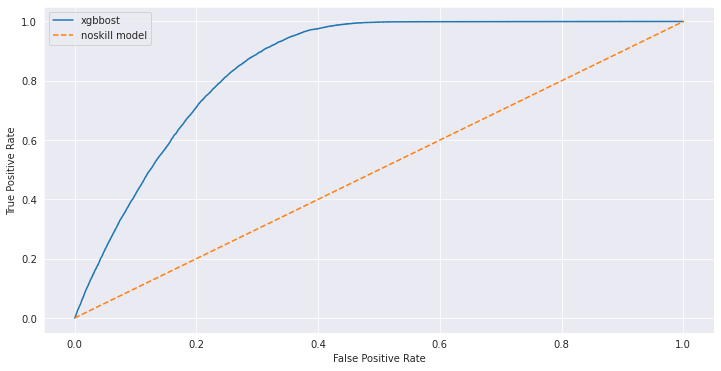

In [124]:
plt.figure(figsize=(12,6))
ident = [0.0, 1.0]
plt.plot(fpr, tpr)
plt.plot(ident, ident, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['xgbbost', 'noskill model'])

Therefore,the best perfoming algorithm on the validation set is extreme gradient boosting *i.e.* XGBoosting and we choose it as our final optimized model.

## Use the optimized model to make predictions on the test set 

In [125]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [126]:
print("the shape of the test dataset is : {}".format(test_df.shape))

the shape of the test dataset is : (127037, 11)


In [127]:
# encoding binary categorical features
test_df.replace({'Male':0, 'Female':1, 'No':0, 'Yes':1}, inplace=True)

# create dummy variables for the categorical feature with more than two classes
final_test_df = pd.get_dummies(test_df, drop_first=True)
final_test_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,381110,0,25,1,11.0,1,0,35786.0,152.0,53,1,0
1,381111,0,40,1,28.0,0,1,33762.0,7.0,111,0,0
2,381112,0,47,1,28.0,0,1,40050.0,124.0,199,0,0
3,381113,0,24,1,27.0,1,1,37356.0,152.0,187,1,0
4,381114,0,27,1,28.0,1,0,59097.0,152.0,297,1,0


In [128]:
# load the trained model
clf_model = pickle.load(open("model_xgb.pickle", "rb")) 

In [132]:
# predict the probability of the minority class (positive response) on the test set
test_pred = clf_model.predict_proba(final_test_df.iloc[:, 1:])[:, 1:]
test_pred

array([[3.1744220e-04],
       [3.7252092e-01],
       [3.0379432e-01],
       ...,
       [1.1746211e-04],
       [1.6278808e-04],
       [6.7393068e-04]], dtype=float32)

In [133]:
submission_df = pd.read_csv("sample_submission.csv")
submission_df.head()

,id,Response
0,381110,0
1,381111,0
2,381112,0
3,381113,0
4,381114,0


In [134]:
submission_df['Rsponse'] = test_pred
submission_df.head(10)

,id,Response,Rsponse
0,381110,0,0.000317
1,381111,0,0.372521
2,381112,0,0.303794
3,381113,0,0.002348
4,381114,0,0.000192
5,381115,0,0.000326
6,381116,0,0.000222
7,381117,0,0.000293
8,381118,0,0.362294
9,381119,0,0.001270


In [ ]:
pd.